# 6. Entrenar modelos de regresión con KNN y DT usando los rasgos de la red preentrenada. 

## Introduction.

As the result of comparing many models with pycaret showed us, the best models that we had were the KNN and DT models, so they're what we will be using through this notebook.

In [1]:
# Importando Librerias.
import tensorflow as tf

# Verificar si se está utilizando la GPU.
if tf.test.gpu_device_name():
    print('GPU encontrada.')
else:
    print("No se encontró GPU. Se utilizará la CPU.")

# Librerias adicionales:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression as LR

GPU encontrada.


In [2]:
# Librerias extra para los modelos de regresion.
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

Something important to take in count is that we will be using the original data what we had at the beginning of the proyect to train the models, this means that we will be loading the hf_files and doing its respective preprocessing.

In [3]:
# Configurando directorio principal como string.
directorio = "C:/Users/marit/Documents/UPY Estancia I/latpar_project/LatPars_SuperModel/"

# Cargando archivos necesarios usando nuestro string de directorio.
hfxrd = np.load(directorio + 'hf_0100.npy')
y = np.load("C:/Users/marit/Documents/UPY Estancia I/latpar_project/latpars.npy")

In [4]:
# Ultimo archivo importante extra.
db = pd.read_csv(r"C:/Users/marit/Documents/UPY Estancia I/latpar_project/db_peaks.csv")

In [5]:
# Cragando CSVs con nuestra Data.
dftest = pd.read_csv(directorio + 'dftest.csv')
dftraval = pd.read_csv(directorio + 'dftraval.csv')

In [6]:
for row in range(db.shape[0]):
    db.at[row,'name'] = db['name'][row][:7]

In [7]:
dftest = pd.read_csv(directorio + 'dftest.csv')
dftraval = pd.read_csv(directorio + 'dftraval.csv')

for row in range(dftest.shape[0]):
    dftest.at[row, 'name'] = dftest['name'][row][:7]
    
for row in range(dftraval.shape[0]):
    dftraval.at[row, 'name'] = dftraval['name'][row][:7]

ntest = dftest.shape[0]//4
ntraval = dftraval.shape[0]//4

dftest = dftest.iloc[:ntest,:].reset_index(drop=True)
dftraval = dftraval.iloc[:ntraval,:].reset_index(drop=True)

idxtraval = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftraval.name.values])].index]
idxtest = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftest.name.values])].index]

hftest = hfxrd[idxtest]
hftraval = hfxrd[idxtraval]

ytest = y[idxtest]
ytraval = y[idxtraval]

In [8]:
print(hftraval.shape)
print(ytraval.shape)
print(hftest.shape)
print(ytest.shape)

(205331, 480)
(205331, 6)
(15454, 480)
(15454, 6)


In [9]:
sgdiccio = pd.read_csv(r"C:/Users/marit/Documents/UPY Estancia I/latpar_project/sgnum_cif.csv")
sgdiccio = {k:v for k,v in zip(sgdiccio.cif.values, sgdiccio.sgnum.values)}

dbtest = db.take(idxtest).reset_index(drop=True)
dbtraval = db.take(idxtraval).reset_index(drop=True)

dbtest['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtest.name.values]
dbtraval['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtraval.name.values]

In [10]:
cs = dict()

for n in range(1,231):
    
    if n <= 2: cs[n]  = 0;
    elif 2 < n <=15: cs[n] = 1;
    elif 15 < n <=74: cs[n] = 2;
    elif 74 < n <=142: cs[n] = 3;
    elif 142 < n <=167: cs[n] = 4;
    elif 167 < n <=194: cs[n] = 5;
    elif 194 < n <=230: cs[n] = 6;

In [11]:
dbtest['cs'] = [cs.get(i, None) for i in dbtest.sgnum.values]
dbtraval['cs'] = [cs.get(i, None) for i in dbtraval.sgnum.values]

After all the preprocess of the data we retrieve the extracted features after processing the diffraction patterns

Following the models extension method we retrieve the orthonormal vectors to represent the crystal systems and the space groups where each crystal system will be represented as a 16-dimensional vector. We fix that length to have a 400-dimensional vector after adding the extracted features.

In [12]:
orthoset = scipy.stats.ortho_group.rvs(32, random_state=3451)
csos_test = orthoset[dbtest.cs.values]
csos_traval = orthoset[dbtraval.cs.values]

Each space group will be represented as a 230-dimensional vector.

In [13]:
sgoset = scipy.stats.ortho_group.rvs(230, random_state=3451)
sgos_traval = sgoset[dbtraval.sgnum.values-1]
sgos_test = sgoset[dbtest.sgnum.values-1]

## Entrenamiento de Modelos.

In [14]:
# Ejemplo de datos de entrada y salida (arrays de NumPy)   # Implementar random forest y quitar decision tree.
X_train_arrays = hftraval
y_train = ytraval

# Inicializar y entrenar un modelo de regresión KNN
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_arrays, y_train)

# Inicializar y entrenar un modelo de regresión de árbol de decisión
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train_arrays, y_train)

# Evaluar los modelos (esto sería con datos de prueba)
X_test_arrays = hftest
y_test = ytest

predicciones_knn = knn_model.predict(X_test_arrays)
predicciones_dt = dt_model.predict(X_test_arrays)

#Evaluar el rendimiento del modelo
hf_mse_knn = mean_squared_error(y_test, predicciones_knn)
hf_mse_dt = mean_squared_error(y_test, predicciones_dt)

#Imprimir resultados
print("Mean Squared Error KNN:", hf_mse_knn)
print("Mean Squared Error Decision Tree:", hf_mse_dt)

Mean Squared Error KNN: 0.5992365022584255
Mean Squared Error Decision Tree: 1.3529933970904675


In [19]:
#Evaluar el rendimiento del modelo
hf_mse_knn = mean_squared_error(y_test, predicciones_knn[:,:3])
hf_mse_dt = mean_squared_error(y_test, predicciones_dt[:,:3])

#Imprimir resultados
print("Mean Squared Error KNN:", hf_mse_knn)
print("Mean Squared Error Decision Tree:", hf_mse_dt)

ValueError: y_true and y_pred have different number of output (6!=1)

In [15]:
# Calcular el RMSE para el modelo KNN
hf_rmse_knn = np.sqrt(hf_mse_knn)

# Calcular el RMSE para el modelo de árbol de decisión
hf_rmse_dt = np.sqrt(hf_mse_dt)

# Imprimir resultados
print("Root Mean Squared Error KNN:", hf_rmse_knn)
print("Root Mean Squared Error Decision Tree:", hf_rmse_dt)

Root Mean Squared Error KNN: 0.774103676685769
Root Mean Squared Error Decision Tree: 1.1631824435962175


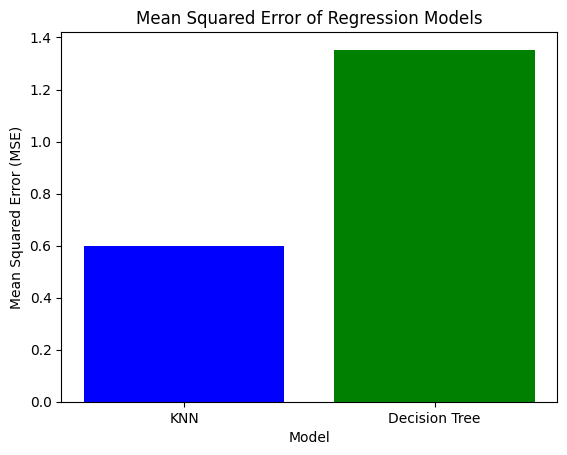

In [16]:
# Crear una lista con los nombres de los modelos
model_names = ['KNN', 'Decision Tree']

# Crear una lista con los valores de los MSE correspondientes
mse_values = [hf_mse_knn, hf_mse_dt]

# Graficar los MSE
plt.bar(model_names, mse_values, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error of Regression Models')
plt.show()

NameError: name 'y_test_flat' is not defined

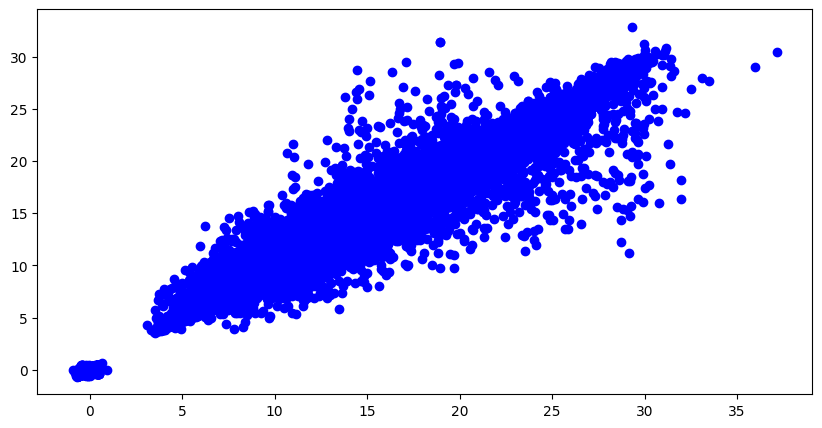

In [17]:
# Crear una figura y ejes para el gráfico de dispersión
plt.figure(figsize=(10, 5))

# Graficar la dispersión para el modelo KNN
plt.scatter(y_test, predicciones_knn, color='blue', label='KNN')

# Graficar la línea diagonal para representar la predicción perfecta
plt.plot([min(y_test_flat), max(y_test_flat)], [min(y_test_flat), max(y_test_flat)], color='red', linestyle='--')

# Etiquetas y título
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Dispersión entre valores reales y predicciones')
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
# Crear una figura y ejes para el gráfico de dispersión
plt.figure(figsize=(10, 5))

# Graficar la dispersión para el modelo de árbol de decisión
plt.scatter(y_test, predicciones_dt, color='green', label='Decision Tree')

# Graficar la línea diagonal para representar la predicción perfecta
plt.plot([min(y_test_flat), max(y_test_flat)], [min(y_test_flat), max(y_test_flat)], color='red', linestyle='--')

# Etiquetas y título
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Dispersión entre valores reales y predicciones')
plt.legend()

# Mostrar el gráfico
plt.show()

## Entrenamiento de Modelos (Datos con sistemas cristalinos).

In [ ]:
rctest = np.concatenate((hftest, csos_test), axis=-1)
rctraval = np.concatenate((hftraval, csos_traval), axis=-1)

In [ ]:
# Ejemplo de datos de entrada y salida (arrays de NumPy)
X_train_arrays = rctraval
y_train = ytraval

# Inicializar y entrenar un modelo de regresión KNN
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_arrays, y_train)

# Inicializar y entrenar un modelo de regresión de árbol de decisión
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train_arrays, y_train)

# Evaluar los modelos (esto sería con datos de prueba)
X_test_arrays = rctest
y_test = ytest

rc_predicciones_knn = knn_model.predict(X_test_arrays)
rc_predicciones_dt = dt_model.predict(X_test_arrays)

#Evaluar el rendimiento del modelo
rc_mse_knn = mean_squared_error(y_test, rc_predicciones_knn)
rc_mse_dt = mean_squared_error(y_test, rc_predicciones_dt)

#Imprimir resultados
print("Mean Squared Error KNN:", rc_mse_knn)
print("Mean Squared Error Decision Tree:", rc_mse_dt)

In [ ]:
# Calcular el RMSE para el modelo KNN
rc_rmse_knn = np.sqrt(rc_mse_knn)

# Calcular el RMSE para el modelo de árbol de decisión
rc_rmse_dt = np.sqrt(rc_mse_dt)

# Imprimir resultados
print("Root Mean Squared Error KNN:", rc_rmse_knn)
print("Root Mean Squared Error Decision Tree:", rc_rmse_dt)

In [ ]:
# Crear una lista con los nombres de los modelos
model_names = ['KNN', 'Decision Tree']

# Crear una lista con los valores de los MSE correspondientes
mse_values = [rc_mse_knn, rc_mse_dt]

# Graficar los MSE
plt.bar(model_names, mse_values, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error of Regression Models')
plt.show()

In [ ]:
# Crear una figura y ejes para el gráfico de dispersión
plt.figure(figsize=(10, 5))

# Graficar la dispersión para el modelo KNN
plt.scatter(y_test, rc_predicciones_knn, color='blue', label='KNN')

# Graficar la línea diagonal para representar la predicción perfecta
plt.plot([min(y_test_flat), max(y_test_flat)], [min(y_test_flat), max(y_test_flat)], color='red', linestyle='--')

# Etiquetas y título
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Dispersión entre valores reales y predicciones')
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
# Crear una figura y ejes para el gráfico de dispersión
plt.figure(figsize=(10, 5))

# Graficar la dispersión para el modelo de árbol de decisión
plt.scatter(y_test, rc_predicciones_dt, color='green', label='Decision Tree')

# Graficar la línea diagonal para representar la predicción perfecta
plt.plot([min(y_test_flat), max(y_test_flat)], [min(y_test_flat), max(y_test_flat)], color='red', linestyle='--')

# Etiquetas y título
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Dispersión entre valores reales y predicciones')
plt.legend()

# Mostrar el gráfico
plt.show()

## Entrenamiento de Modelos (Datos con grupos espaciales).

In [ ]:
spgtest = np.concatenate((hftest, sgos_test), axis=-1)
spgtraval = np.concatenate((hftraval, sgos_traval), axis=-1)

In [ ]:
# Ejemplo de datos de entrada y salida (arrays de NumPy)
X_train_arrays = spgtraval
y_train = ytraval

# Inicializar y entrenar un modelo de regresión KNN
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_arrays, y_train)

# Inicializar y entrenar un modelo de regresión de árbol de decisión
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train_arrays, y_train)

# Evaluar los modelos (esto sería con datos de prueba)
X_test_arrays = spgtest
y_test = ytest

spg_predicciones_knn = knn_model.predict(X_test_arrays)
spg_predicciones_dt = dt_model.predict(X_test_arrays)

#Evaluar el rendimiento del modelo
spg_mse_knn = mean_squared_error(y_test, spg_predicciones_knn)
spg_mse_dt = mean_squared_error(y_test, spg_predicciones_dt)

#Imprimir resultados
print("Mean Squared Error KNN:", spg_mse_knn)
print("Mean Squared Error Decision Tree:", spg_mse_dt)

In [ ]:
# Calcular el RMSE para el modelo KNN
spg_rmse_knn = np.sqrt(spg_mse_knn)

# Calcular el RMSE para el modelo de árbol de decisión
spg_rmse_dt = np.sqrt(spg_mse_dt)

# Imprimir resultados
print("Root Mean Squared Error KNN:", spg_rmse_knn)
print("Root Mean Squared Error Decision Tree:", spg_rmse_dt)

In [ ]:
# Crear una lista con los nombres de los modelos
model_names = ['KNN', 'Decision Tree']

# Crear una lista con los valores de los MSE correspondientes
mse_values = [spg_mse_knn, spg_mse_dt]

# Graficar los MSE
plt.bar(model_names, mse_values, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error of Regression Models')
plt.show()

In [ ]:
# Crear una figura y ejes para el gráfico de dispersión
plt.figure(figsize=(10, 5))

# Graficar la dispersión para el modelo KNN
plt.scatter(y_test, spg_predicciones_knn, color='blue', label='KNN')

# Graficar la línea diagonal para representar la predicción perfecta
plt.plot([min(y_test_flat), max(y_test_flat)], [min(y_test_flat), max(y_test_flat)], color='red', linestyle='--')

# Etiquetas y título
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Dispersión entre valores reales y predicciones')
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
# Crear una figura y ejes para el gráfico de dispersión
plt.figure(figsize=(10, 5))

# Graficar la dispersión para el modelo de árbol de decisión
plt.scatter(y_test, spg_predicciones_dt, color='green', label='Decision Tree')

# Graficar la línea diagonal para representar la predicción perfecta
plt.plot([min(y_test_flat), max(y_test_flat)], [min(y_test_flat), max(y_test_flat)], color='red', linestyle='--')

# Etiquetas y título
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Dispersión entre valores reales y predicciones')
plt.legend()

# Mostrar el gráfico
plt.show()